In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import zscore
from scipy.stats import randint

import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [3]:
df = pd.read_csv('first inten project.csv')
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [14]:
df.info()
#No null values, but some columns will need encoding 
#Binary columns: car parking space, booking status(Tareget variable)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [5]:
def get_outlier_indices(df, columns=None, threshold=3):
    outlier_indices = set() 

    if columns is None:
        columns = df.select_dtypes(include=['number']).columns

    for col in columns:
        z_scores = zscore(df[col])
        col_outliers = df[(z_scores > threshold) | (z_scores < -threshold)].index
        
        outlier_indices.update(col_outliers)

    return list(outlier_indices)


columns_to_check = ['number of adults', 'number of children', 'average price ', 'number of weekend nights',
                    'number of week nights','special requests', 'P-C', 'P-not-C', 'lead time'] 


outlier_indices = get_outlier_indices(df, columns=columns_to_check)
len(outlier_indices)
#I tried with threshold 4, but the accuracy was better with 3

2933

In [6]:
df_cleaned = df.drop(outlier_indices)

In [7]:
df_x = df_cleaned.drop(columns=['booking status', 'Booking_ID', 'date of reservation'])
df_x_encoded = pd.get_dummies(df_x, columns=['type of meal', 'room type', 'market segment type'])
df_y = pd.get_dummies(df_cleaned, columns=['booking status'])
df_x = df_cleaned.drop(columns=['booking status', 'Booking_ID'])
X = df_x_encoded 
y = df_cleaned['booking status']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

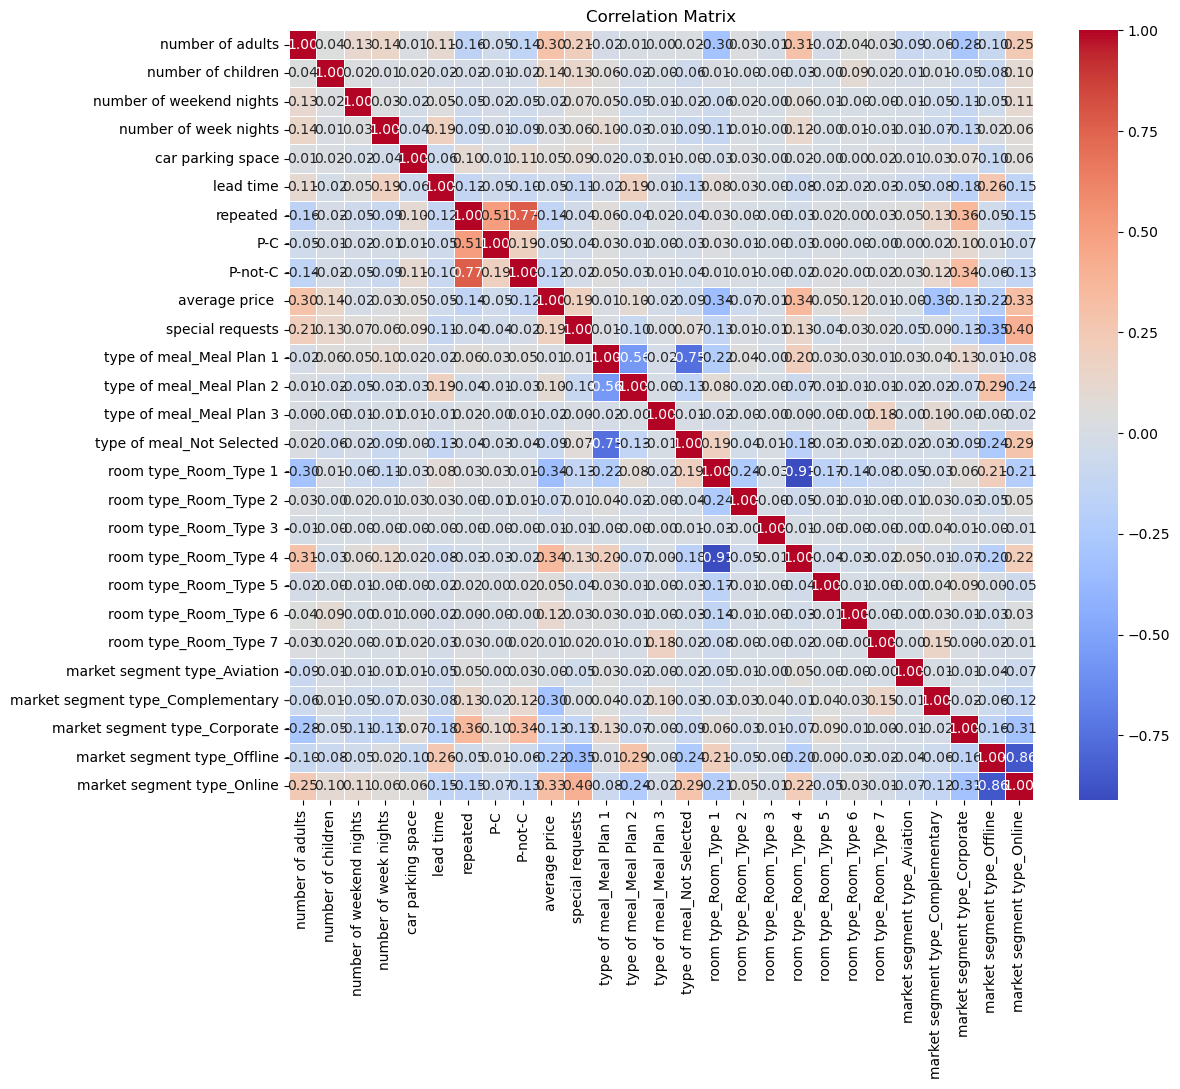

In [18]:
correlation_matrix = df_x_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
#P-not-C is correlated with repeated. Maybe one needs to get dropped (leaving it or removing it does not make a difference,
#so we should remove it to decraese the number of features in the model)
#ALso the dummy variables for room type 1 and 4 are highly correlated
#After trying removing any of them does not improve the accuracy 

In [ ]:
#I tried adding features like total number of nights, total number of guests and a boolean column for special requests, and 
#another boolean column to tell me if the date of reservation was a weekday or a weekend 
#But they decreased the accuracy so it is better to use the features as is 

'''
df['total_guests'] = df['number of adults'] + df['number of children']
df['total_nights'] = df['number of weekend nights'] + df['number of week nights']
df['has_special_requests'] = df['special requests'].apply(lambda x: 1 if x > 0 else 0)

df['date of reservation'] = pd.to_datetime(df['date of reservation'])
df['is_weekend'] = df['date of reservation'].dt.weekday >= 5  # Saturday=5, Sunday=6
df['is_weekend'] = df['is_weekend'].astype(int)
'''


In [14]:
#Logistic Regression
logistic_regression = LogisticRegression(random_state=42)

# Train Logistic Regression model
logistic_regression.fit(X_train, y_train)

# Make predictions
y_pred = logistic_regression.predict(X_test)

#Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
# Train Decision Tree
decision_tree.fit(X_train, y_train)
# Make predictions
y_pred_tree = decision_tree.predict(X_test)

#Random Forest
# Train Random Forest
random_forest.fit(X_train, y_train)
# Make predictions
y_pred_forest = random_forest.predict(X_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize Logistic Regression model
logistic_regression = LogisticRegression(random_state=42)

# Train Logistic Regression model
logistic_regression.fit(X_train, y_train)

# Make predictions
y_pred = logistic_regression.predict(X_test)

# Evaluate Logistic Regression model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Evaluate Decision Tree
print("Decision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))

# Evaluate Random Forest
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_forest))


#The Random Forest Performed the best 

C:\Users\Lobna\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Performance:
Accuracy: 0.7965220867479512
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64      3175
           1       0.82      0.90      0.86      6831

    accuracy                           0.80     10006
   macro avg       0.77      0.74      0.75     10006
weighted avg       0.79      0.80      0.79     10006

Decision Tree Performance:
Accuracy: 0.8527883270037977
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      3175
           1       0.90      0.88      0.89      6831

    accuracy                           0.85     10006
   macro avg       0.83      0.84      0.83     10006
weighted avg       0.86      0.85      0.85     10006

Random Forest Performance:
Accuracy: 0.88916650009994
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      3

C:\Users\Lobna\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Grid Search for the decision tree
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],               
    'min_samples_split': [2, 5, 10],                        
    'min_samples_leaf': [1, 2, 4],                          
    'max_features': [None, 'sqrt', 'log2'],                 
    'criterion': ['gini', 'entropy']                        
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),                
    param_grid,                                              
    cv=5,                                                    
    scoring='accuracy'                                     
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best estimator
best_tree = grid_search.best_estimator_




Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


C:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [15]:
#Decision Tree after the grid search 
decision_tree_after = DecisionTreeClassifier(criterion='gini', 
    max_depth=10, 
    max_features=None, 
    min_samples_leaf=2, 
    min_samples_split=5, 
    random_state=42)

# Train Decision Tree
decision_tree_after.fit(X_train, y_train)
# Make predictions
y_pred_tree_after = decision_tree_after.predict(X_test)

print("Decision Tree Performance after Grid Search:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree_after)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tree_after))

#Slightly better but the random forest is still better

Decision Tree Performance after Grid Search:
Accuracy: 0.8660803517889266
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      3175
           1       0.90      0.91      0.90      6831

    accuracy                           0.87     10006
   macro avg       0.85      0.84      0.84     10006
weighted avg       0.87      0.87      0.87     10006



In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],               
    'max_depth': [10, 20, 30, None],               
    'min_samples_split': [2, 10, 20],              
    'min_samples_leaf': [1, 5, 10],                
    'max_features': ['auto', 'sqrt', None],        
    'class_weight': ['balanced', 'balanced_subsample', None]  
}


random_forest = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search.fit(X_train, y_train)


print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)


best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)


print("Random Forest Performance with Best Hyperparameters:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_best_rf))
#Too heavy for my laptop to run

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


In [19]:
from scipy.stats import randint


param_dist = {
    'n_estimators': randint(100, 500),          
    'max_depth': randint(5, 20),                
    'min_samples_split': randint(2, 20),        
    'min_samples_leaf': randint(1, 10),         
    'max_features': ['auto', 'sqrt'],           
    'bootstrap': [True, False],                 
    'criterion': ['gini', 'entropy'],           
    'class_weight': ['balanced', None]          
}


random_forest_after = RandomForestClassifier(random_state=42)


random_search = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_dist,
    n_iter=50,             
    cv=5,                  
    verbose=2,             
    random_state=42,
    n_jobs=-1              
)


random_search.fit(X_train, y_train)


print("Best hyperparameters:", random_search.best_params_)


best_model = random_search.best_estimator_
y_pred_forest_after = best_model.predict(X_test)


print("Random Forest Performance after Randomized Search:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest_after)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_forest_after))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\Lobna\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
125 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
62 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lobna\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lobna\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Lobna\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 666, in _validate_params
    valid

Best hyperparameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 416}
Random Forest Performance after Randomized Search:
Accuracy: 0.8856685988406956
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      3175
           1       0.92      0.91      0.92      6831

    accuracy                           0.89     10006
   macro avg       0.87      0.87      0.87     10006
weighted avg       0.89      0.89      0.89     10006



In [11]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned['booking status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

print("LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)


print("XGBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

#The Random Forest is still better 

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17971, number of negative: 8710
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 26681, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.673550 -> initscore=0.724288
[LightGBM] [Info] Start training from score 0.724288
LightGBM Performance:
Accuracy: 0.8712336980962374
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      2090
           1       0.89      0.93      0.91      4581

    accuracy                           0.87      6671
   macro avg       0.86      0.83      0.85      6671

In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error


results = {
    'Model': [],
    'Accuracy': []
}

# Logistic Regression
y_pred_logistic = logistic_regression.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
results['Model'].append('Logistic Regression')
results['Accuracy'].append(accuracy_logistic)

# Decision Tree
y_pred_tree = decision_tree.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
results['Model'].append('Decision Tree')
results['Accuracy'].append(accuracy_tree)

# Random Forest
y_pred_forest = random_forest.predict(X_test)
accuracy_forest = accuracy_score(y_test, y_pred_forest)
results['Model'].append('Random Forest')
results['Accuracy'].append(accuracy_forest)

# XGBoost
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
results['Model'].append('XGBoost')
results['Accuracy'].append(accuracy_xgb)

# LightGBM
y_pred_lgb = lgb_model.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
results['Model'].append('LightGBM')
results['Accuracy'].append(accuracy_lgb)


results_df = pd.DataFrame(results)


print(results_df)


                 Model  Accuracy
0  Logistic Regression  0.796522
1        Decision Tree  0.852788
2        Random Forest  0.889167
3              XGBoost  0.888467
4             LightGBM  0.877973
